In [1]:
import math
import numpy as np
import pandas as pd
import skimage 
import src
import src.datasets
import os
import scipy
import sklearn
import sklearn.datasets
import seaborn as sns

from sklearn.inspection import DecisionBoundaryDisplay
from src.optimal_transport_modules import icnn_modules as icnn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from torchvision import transforms
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
from sklearn.metrics import balanced_accuracy_score

from src.evaluation import load_iccns
from src.utils import set_random_seeds
from hydra import initialize, compose
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn
from torch.nn import functional as F
from skimage.segmentation import mark_boundaries
from lime import lime_image
from sklearn import svm, tree
from aif360.sklearn.metrics import equal_opportunity_difference
from sklearn.neural_network import MLPClassifier

In [2]:
%matplotlib inline

In [3]:
set_random_seeds(53)

# Experiment 3

In [4]:
def approximate_distance_from_decision_boundary(clf, 
                                                x,
                                               quadratic=True,
                                               sample_size = 10000,
                                               max_iter=20,
                                               var=1.0):
    
    i = 0
    
    Z = np.random.multivariate_normal(x, cov=var*np.identity(2), size=sample_size)
    
    # compute clf in the neighbourhood
    pred = clf.predict(Z)
    
    while (0 <= i < max_iter) and ((pred == 1).sum() == 0 or (pred == 0).sum() == 0):
        Z = np.random.multivariate_normal(x, cov=var*np.identity(2), size=sample_size)
    
        pred = clf.predict(Z)
        
        i+=1
        
    # assign weights
    weight = np.array([np.exp(-.5*np.linalg.norm(x - z)**2) for z in Z])

    # train SVM
    lin_svm = svm.LinearSVC(C=.1)
    lin_svm.fit(Z, pred, sample_weight=weight)
    
    # compute distance from decision boundary
    if quadratic:
        distance = .5*(lin_svm.decision_function(x.reshape(1,-1))/np.linalg.norm(lin_svm.coef_))**2
    
    else: 
        distance = lin_svm.decision_function(x.reshape(1,-1))/np.linalg.norm(lin_svm.coef_)
    
    return distance

In [5]:
size = 5000

model_names = ["linear_svm",
               "kernel_svm",
               "dt_5", 
               "dt_50",
               "nn_3",
               "nn_10"]

experiments = ["blobs",
               "moons",
               "circles",
               "circles_plus"]

data = dict()
ground_truth = dict()

for name in experiments:
    temp = np.load("../data/toy/{}.npy".format(name))
    data[name] = temp[:, :-1]
    ground_truth[name] = temp[:, -1]

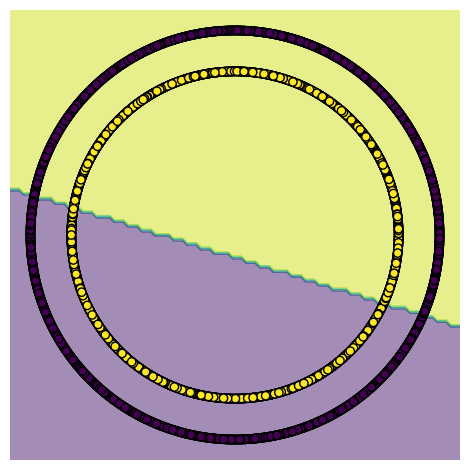

KeyboardInterrupt: 

In [88]:
distances = dict()
name = "circles"

distances[name] = dict()

X = data[name]
y = ground_truth[name]

models = {"linear_svm" : svm.LinearSVC(C=.01),
          "nn_10" : MLPClassifier(hidden_layer_sizes=(100,)*10)}

for model_name, model in models.items():
    
    model.fit(X, y)

    if model_name == "linear_svm":
        d = (.5*(model.decision_function(X)/
             np.linalg.norm(model.coef_))**2)
        
        distances[name][model_name] = d.mean()
    
    else:
        d = np.array(
        [approximate_distance_from_decision_boundary(model, x) for x in X])
            
        distances[name][model_name] = d.mean()
        
    
    disp = DecisionBoundaryDisplay.from_estimator(
                        model,
                        X,
                        response_method="predict",
                        xlabel=None,
                        ylabel=None,
                        alpha=0.5,
                        cmap = "viridis")

    disp.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k",
                        cmap = "viridis")
    
    disp.ax_.axis("off")
    disp.ax_.set_xlim(-11,11)
    disp.ax_.set_ylim(-11,11)
    disp.ax_.set_box_aspect(1)
    
    plt.tight_layout()
    
    #plt.savefig("../results/Experiment3/circles_{}.png".format(model_name))
    plt.show()

In [7]:
from src.optimal_transport_modules.icnn_modules import *
from src.evaluation import compute_optimal_transport_map
from src.datasets import Toy_Dataset

path_f = ("../results/training/toy/2023-02-06/11-15-45/storing_models/convex_f_epoch_25.pt")

convex_f = Simple_Feedforward_4Layer_ICNN_LastInp_Quadratic(
                    2,
                    64,
                    "leaky_relu")

convex_f.load_state_dict(
        torch.load(path_f))

convex_f.eval()

path_g = ("../results/training/toy/2023-02-06/10-06-32/storing_models/convex_g_epoch_25.pt")

convex_g = Simple_Feedforward_4Layer_ICNN_LastInp_Quadratic(
                    2,
                    64,
                    "leaky_relu")

convex_g.load_state_dict(
        torch.load(path_g))

convex_g.eval()

class Dataset(nn.Module):

    def __init__(self, path, ground_truth = 1):
        super(Dataset, self).__init__()
        temp = np.load(path)
        temp = temp[temp[:,-1] == ground_truth]

        self.X = temp[:, :-1]
        self.y = temp[:,-1]

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, item):
        self.X[item]
        return torch.from_numpy(self.X[item]), self.y[item]

def compute_OT_loss(X_data, Y_data, convex_f, convex_g, cuda = False):

    Y_loader = torch.utils.data.DataLoader(Y_data,
                                       batch_size=1)
    OT_loss = list()
    y_sq = list()
    for batch, _ in Y_loader:

        if cuda:
            batch = batch.cuda()
            
        batch = batch.float()
        batch.requires_grad = True

        grad_g_of_batch = compute_optimal_transport_map(batch, convex_g)

        f_grad_g_batch = convex_f(grad_g_of_batch)
        dot_prod = (grad_g_of_batch * batch).sum()

        loss_g = f_grad_g_batch - dot_prod
        OT_loss.append(loss_g.item())
        y_sq.append(.5 * (batch.pow(2).sum().item()))

    X_loader = torch.utils.data.DataLoader(X_data,
                                           batch_size=1,
                                           shuffle=True)
    f_values = list()
    x_sq = list()
    for batch, _ in X_loader:
        
        batch = batch.float()
        if cuda:
            batch = batch.cuda()

        f_values.append(convex_f(batch).item())
        x_sq.append(.5 * (batch.pow(2).sum().item()))
    

    return np.array(OT_loss).mean() - np.array(f_values).mean() + np.array(x_sq).mean() + np.array(y_sq).mean()

X_data = Dataset(
                "../data/toy/circles.npy",
                ground_truth = 0)


Y_data = Dataset(
                  "../data/toy/circles.npy",
                  ground_truth = 1)

wass = compute_OT_loss(X_data, Y_data, convex_f, convex_g)

In [89]:
x = data[name]
y = ground_truth[name]

In [90]:
kwegyir = 0

for x0 in x[y==0]:
    xx = 0
    for x1 in x[y==1]:
        xx += 0.5*np.linalg.norm(x0 - x1)**2
    kwegyir += xx/len(x[y==1])

kwegyir = xx/len(x[y==0])

In [91]:
kwegyir

82.00000000000001

In [98]:
xx = np.exp(.5*np.array([-np.linalg.norm(p - x[y==0], axis=1)**2 for p in x[y==0]])).sum()/(len(x[y==0])**2)
yy = np.exp(.5*np.array([-np.linalg.norm(p - x[y==1], axis=1)**2 for p in x[y==1]])).sum()/(len(x[y==1])**2)
xy = np.exp(.5*np.array([-np.linalg.norm(p - x[y==0], axis=1)**2 for p in x[y==1]])).sum()/(len(x[y==0])*len(x[y==1]))

mmd_sq = xx + yy - 2*xy

mmd_sq

0.0778186874885219

In [132]:
def kernel(a, b):
    return np.exp(0.5*(-np.linalg.norm(a-b)**2))

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)

In [133]:
MMD(torch.Tensor(x[y==0]), torch.Tensor(x[y==1]), "rbf")

tensor(0.0778)

In [120]:
np.matmul(x, x.T).diagonal()

array([ 64.,  64., 100., ...,  64.,  64.,  64.])

In [126]:
MMD(x[y==0], x[y==1], "rbf")

array([[ 1.84500063e+00, -1.07325181e-02,  2.98944115e-18, ...,
         8.09418478e-01,  2.00215969e-03,  1.49184369e-01],
       [ 9.19491728e-02,  2.00000000e+00, -1.69487668e-11, ...,
         1.23506218e-01,  1.70395220e-06,  2.27656994e-04],
       [ 3.17714376e-18,  1.26614275e-11,  2.00000000e+00, ...,
         1.30618506e-16,  1.13742967e-01,  5.19781917e-02],
       ...,
       [ 9.90144794e-01,  1.23506218e-01,  1.30618506e-16, ...,
         2.00000000e+00,  5.40448590e-06,  1.13720947e-01],
       [-2.73318180e-02, -8.47798463e-06,  1.13742967e-01, ...,
        -2.08436502e-02,  2.00000000e+00, -2.70055775e-01],
       [ 1.50704266e-01,  2.27656994e-04,  5.19781917e-02, ...,
         1.13742967e-01,  9.00782298e-18,  2.00000000e+00]])

In [107]:
np.linalg.norm(x[y==0][1] - x[y==0], axis=1)**2 

array([255.07378203,   0.        , 380.53508612, ..., 380.96541049,
       318.36887452, 354.42256576])

In [18]:
print(distances)
print(wass)
print(kwegyir)

{'circles': {'linear_svm': 21.052569236746205, 'nn_10': 1.2193835391009498}}


NameError: name 'wass' is not defined

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


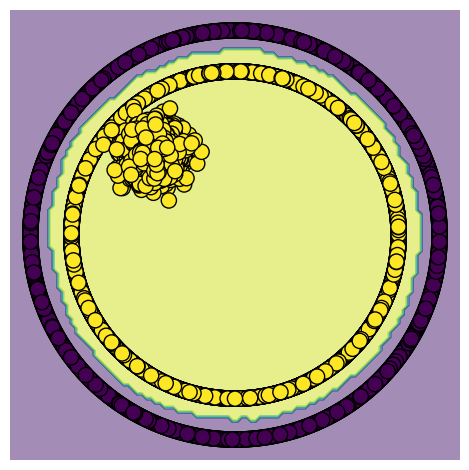

In [9]:
distances_ind = dict()
name = "circles_plus"

distances_ind[name] = dict()

X = data[name]
y = ground_truth[name]

models = {"nn_10" : MLPClassifier(hidden_layer_sizes=(100,)*10)}

for model_name, model in models.items():
    model.fit(X, y)

    if model_name == "linear_svm":
        d = (model.decision_function(X[y==1])/
             np.linalg.norm(model.coef_))
        
        distances_ind[name][model_name] = d
    
    else:
        d = np.array(
        [approximate_distance_from_decision_boundary(model, x, quadratic = False, var=10) for x in X[y==0]])
            
        distances_ind[name][model_name] = d
    
    disp = DecisionBoundaryDisplay.from_estimator(
                        model,
                        X,
                        response_method="predict",
                        xlabel=None,
                        ylabel=None,
                        alpha=0.5)

    disp.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", s=120)
    
    disp.ax_.axis("off")
    disp.ax_.set_xlim(-11,11)
    disp.ax_.set_ylim(-11,11)
    disp.ax_.set_box_aspect(1)
    
    plt.tight_layout()
    
    plt.savefig("../results/Experiment3/circles_plus_{}.eps".format(model_name), format="eps")
    plt.show()

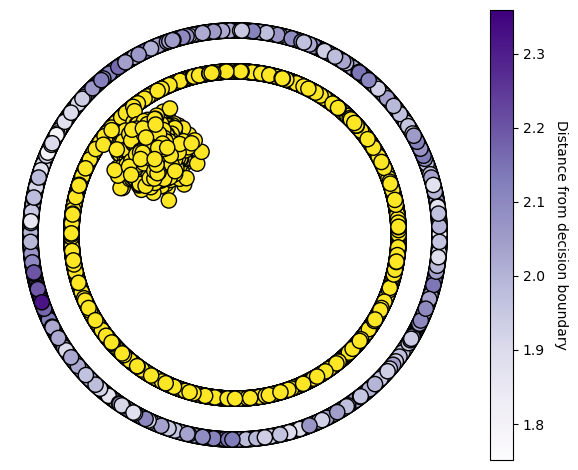

In [10]:
model = models["nn_10"]

def f(x,y):
    distance = -approximate_distance_from_decision_boundary(model,
                                                           np.array([x,y]),
                                                           quadratic = False,
                                                           var=10)
    return distance
    
points = data["circles_plus"]
gt = ground_truth["circles_plus"]

x = points[gt == 0]
y = points[gt == 1]

Z = np.vectorize(f)(x[:,0], x[:,1])

fig, ax = plt.subplots()
sc = ax.scatter(x[:, 0], x[:, 1], c=Z, cmap="Purples" ,edgecolor="k", s=120)

cbar = plt.colorbar(sc)
cbar.set_label("Distance from decision boundary", rotation=270, labelpad=17)
 
ax.scatter(y[:, 0], y[:, 1], c=gt[gt==1], cmap = "viridis_r", edgecolor="k", s=120)

ax.axis("off")
ax.set_xlim(-11,11)
ax.set_ylim(-11,11)
ax.set_box_aspect(1)

plt.tight_layout()

plt.savefig("../results/Experiment3/circles_plus_nn_10_distances.eps", format="eps")
plt.show()

In [11]:
from src.optimal_transport_modules.icnn_modules import *

path = ("../results/training/toy/2023-02-06/11-18-13/storing_models/convex_f_epoch_25.pt")

convex_f = Simple_Feedforward_4Layer_ICNN_LastInp_Quadratic(
                    2,
                    64,
                    "leaky_relu")

convex_f.load_state_dict(
        torch.load(path))

convex_f.eval()


Simple_Feedforward_4Layer_ICNN_LastInp_Quadratic(
  (fc1_normal): Linear(in_features=2, out_features=64, bias=True)
  (activ_1): LeakyReLU(negative_slope=0.2)
  (fc2_normal): Linear(in_features=2, out_features=64, bias=True)
  (fc2_convex): ConvexLinear(in_features=64, out_features=64, bias=False)
  (activ_2): LeakyReLU(negative_slope=0.2)
  (fc3_normal): Linear(in_features=2, out_features=64, bias=True)
  (fc3_convex): ConvexLinear(in_features=64, out_features=64, bias=False)
  (activ_3): LeakyReLU(negative_slope=0.2)
  (fc4_normal): Linear(in_features=2, out_features=64, bias=True)
  (fc4_convex): ConvexLinear(in_features=64, out_features=64, bias=False)
  (activ_4): LeakyReLU(negative_slope=0.2)
  (last_convex): ConvexLinear(in_features=64, out_features=1, bias=False)
  (last_linear): Linear(in_features=2, out_features=1, bias=True)
)

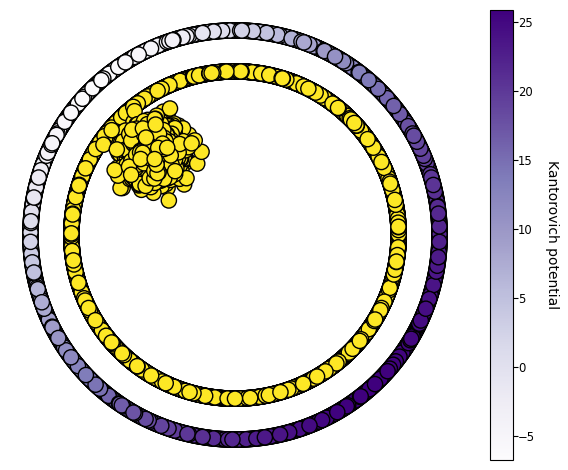

In [12]:
model = models["nn_10"]

def f(a, b):
    arr = np.array([a,b])
    potential = .5*np.linalg.norm(arr)**2 - convex_f(torch.from_numpy(arr).float())
    return potential.detach().numpy()

points = data["circles_plus"]
gt = ground_truth["circles_plus"]

x = points[gt == 0]
y = points[gt == 1]

Z = np.vectorize(f)(x[:,0], x[:,1])

fig, ax = plt.subplots()
sc = ax.scatter(x[:, 0], x[:, 1], c=Z, cmap="Purples" ,edgecolor="k", s=120)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(axis='both', which='major', pad=0, labelsize = "small")
cbar.set_label("Kantorovich potential", rotation=270, labelpad=17)

ax.scatter(y[:, 0], y[:, 1], c=gt[gt==1], cmap = "viridis_r", edgecolor="k", s=120)

ax.axis("off")
ax.set_xlim(-11,11)
ax.set_ylim(-11,11)
ax.set_box_aspect(1)

plt.tight_layout()

plt.savefig("../results/Experiment3/circles_plus_potentials.eps", format="eps")
plt.show()

In [ ]:
[(np.linalg.norm(p - data[name], axis=1)**2).sum()/(len(data[name])-1) for p in data[name]]

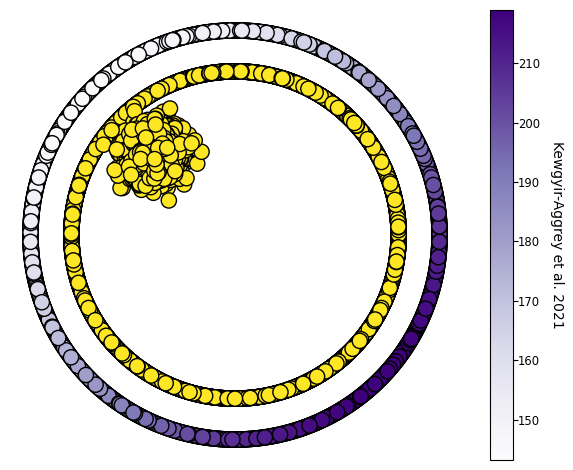

In [32]:
points = data["circles_plus"]
gt = ground_truth["circles_plus"]

x = points[gt == 0]
y = points[gt == 1]

Z = [.5*(np.linalg.norm(p - y, axis=1)**2).sum()/(len(x)) for p in x]

fig, ax = plt.subplots()
sc = ax.scatter(x[:, 0], x[:, 1], c=Z, cmap="Purples" ,edgecolor="k", s=120)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(axis='both', which='major', pad=0, labelsize = "small")
cbar.set_label("Kewgyir-Aggrey et al. 2021", rotation=270, labelpad=17)

ax.scatter(y[:, 0], y[:, 1], c=gt[gt==1], cmap = "viridis_r", edgecolor="k", s=120)

ax.axis("off")
ax.set_xlim(-11,11)
ax.set_ylim(-11,11)
ax.set_box_aspect(1)

plt.tight_layout()

plt.savefig("../results/Experiment3/circles_plus_kwegyir.eps", format="eps")
plt.show()